In [1]:
import numpy as np
import pandas as pd

import os
import tqdm

import matplotlib.pyplot as plt

from midi_utils.encoding_decoding import parse_directory
from midi_utils.preprocessing import split_and_transpose

# Import Data

In [2]:
wd = os.getcwd()

lute_df_path = os.path.join(wd, 'data', 'data_sets', 'lute_data.csv')
lute_df = pd.read_csv(lute_df_path)
lute_df['Date'] = lute_df['Date'].str.replace('[^0-9]','', regex=True).astype(int)

composer_df_path = os.path.join(wd, 'data', 'data_sets', 'scraped_composer_data.csv')
composer_df = pd.read_csv(composer_df_path, encoding='latin-1')

# rename composers in the main dataset
names_df_path = os.path.join(wd, 'data', 'data_sets', 'composer_names.csv')
names_df = pd.read_csv(names_df_path, encoding='latin-1', index_col='Composer')
lute_df['Composer'] = lute_df['Composer'].apply(lambda x: names_df.loc[x].cleaned_name)

# merge piece data with composer data 
lute_df_comp = lute_df.merge(composer_df, how='left', left_on='Composer', right_on='composer').copy()

# Select a Subset of the Data

## Subset 1: All Solo Renaissance Lute Pieces

In [3]:
ren_lute_instruments = ['10-course', '9-course', '8-course', '7-course', '6-course']
important_keys = ['Gm', 'GM', 'Cm', 'CM', 'Dm', 'DM', 'Fm', 'FM']


ren_lute_df = lute_df_comp.query(
    'Ensemble in @ren_lute_instruments'
    ' and Key in @important_keys'
    ' and Type != "exercise"'
    ' and Date > 1500'
    ' and Date < 1650'
)

len(ren_lute_df)

11685

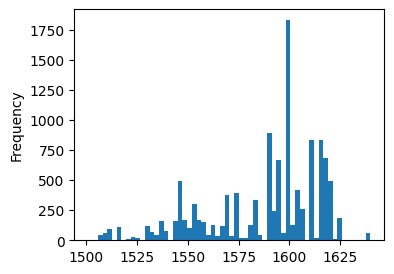

In [4]:
ren_lute_df.Date.plot(kind='hist', bins=60, figsize=(4,3))
plt.show()

## Subset 2: English Galliards, Pavanes, and Allemandes

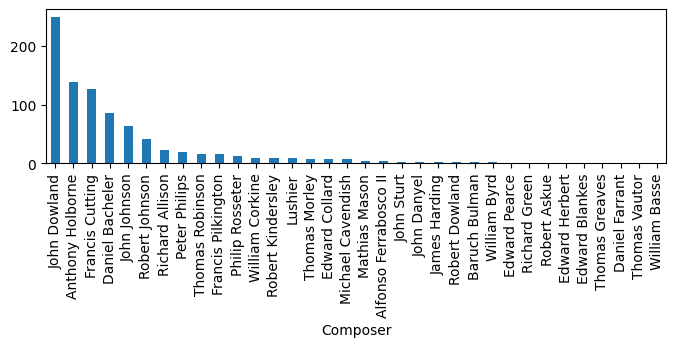

In [5]:
ren_lute_instruments = ['10-course', '9-course', '8-course', '7-course', '6-course']
important_comp_types = ['galliard', 'pavane', 'allemande']
important_keys = ['Gm', 'GM', 'Cm', 'CM', 'Dm', 'DM', 'Fm', 'FM']

lute_data_subset = lute_df_comp.query(
    'nationality == "England"'
    ' and Ensemble in @ren_lute_instruments'
    ' and Type in @important_comp_types'
    ' and Date > 1580 and Date < 1650'
    ' and Key in @important_keys'
).copy()

lute_data_subset.value_counts('Composer').plot(kind='bar', figsize=(8,2))
plt.show()

In [6]:
important_composers = lute_data_subset.value_counts('Composer').index.to_numpy()[:8]
lute_data_subset = lute_data_subset.query('Composer in @important_composers')

print(f'The selected subset contains {len(lute_data_subset)} pieces.')

The selected subset contains 744 pieces.


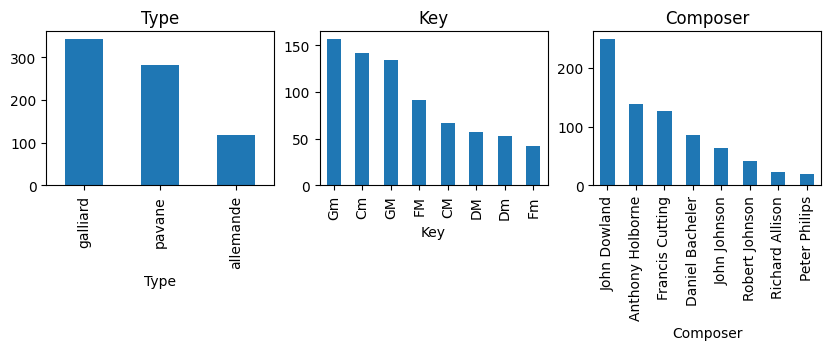

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))

lute_data_subset.Type.value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Type')

lute_data_subset.Key.value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Key')

lute_data_subset.Composer.value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('Composer')

plt.show()

# Download MIDIs

In [8]:
def download_midi_files(df, directory):
    """
    Download MIDI files from URLs specified in a DataFrame and save them to a directory.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing a column 'Midi' with URLs of MIDI files to download.
    - directory (str): Directory to save the downloaded MIDI files.

    Returns:
    None

    Notes:
    - Each MIDI file is saved with a filename in the format 'file_index.mid' where 'index' corresponds to its row index in the DataFrame.
    """
    def download_file(url, index):
        try:
            response = requests.get(url)
            response.raise_for_status()
            filename = os.path.join(directory, f"file_{index}.mid")
            with open(filename, mode="wb") as f:
                f.write(response.content)
        except requests.exceptions.RequestException as e:
            print(f"Error downloading file {index}: {e}")
    
    urls = df['Midi'].to_list()
    os.makedirs(directory, exist_ok=True)

    with ThreadPoolExecutor() as executor:
        executor.map(download_file, urls, df.index.to_list())

# Extract Sequential Text Representation from MIDIs

In [10]:
midi_directory = os.path.join(wd, 'data', 'midi_files', 'english_pieces')

midi_data = parse_directory(midi_directory, round_values=True)

parsed_midis = midi_data['parsed_midis']
agg_stats = midi_data['agg_stats']

  0%|▎                                                                                 | 3/738 [00:00<00:32, 22.79it/s]

Error parsing desktop.ini: MThd not found. Probably not a MIDI file


100%|████████████████████████████████████████████████████████████████████████████████| 738/738 [00:21<00:00, 34.12it/s]


Number of pieces: 737
Number of tokens: 1586640


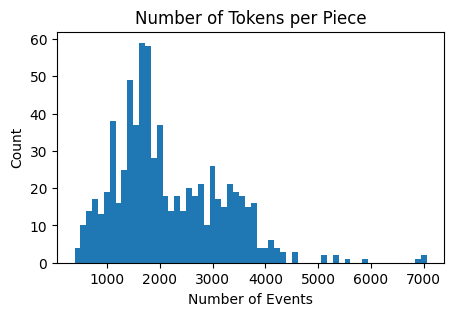

In [11]:
event_data = [parsed_midis[key]['events'] for key, value in parsed_midis.items()]
piece_lengths = [len(piece) for piece in event_data]

print(f'Number of pieces: {len(event_data)}')
print(f'Number of tokens: {sum(piece_lengths)}')

fig = plt.figure(figsize=(5,3))
plt.hist(piece_lengths, bins=60)
plt.xlabel('Number of Events')
plt.ylabel('Count')
plt.title('Number of Tokens per Piece')
plt.show()

# Data Cleaning

In [12]:
files_to_remove = set()

## Pitch

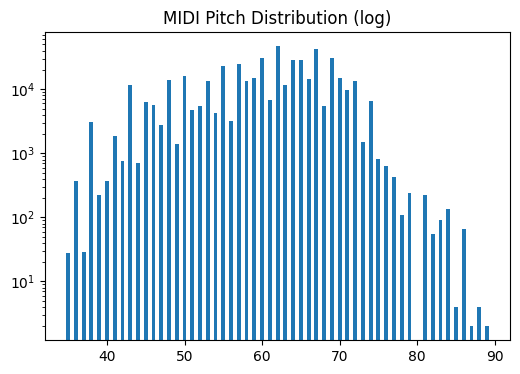

In [13]:
pitch_counts = agg_stats['pitch_counts']

fig = plt.figure(figsize=(6,4))
plt.bar(list(pitch_counts.keys()), list(pitch_counts.values()), width=0.5)
plt.yscale('log')
plt.title('MIDI Pitch Distribution (log)')
plt.show()

In [14]:
# files with MIDI pitches <= 20

sus_files = []
for file, data in parsed_midis.items():
    pitch_distribution = data['pitch_counts']
    for i in range(21):
        if pitch_distribution.get(0) != None:
            sus_files.append(file)
            break

sus_files = set(sus_files)
print(sus_files)

set()


In [15]:
files_to_remove.update(sus_files)

The range of a 6-course renaissance lute in G goes from 43 (G2) to 79 (G5), maybe a little higher in some cases. With more courses the bass range can be extended, but pitches below 36 (C2) should be very rare.

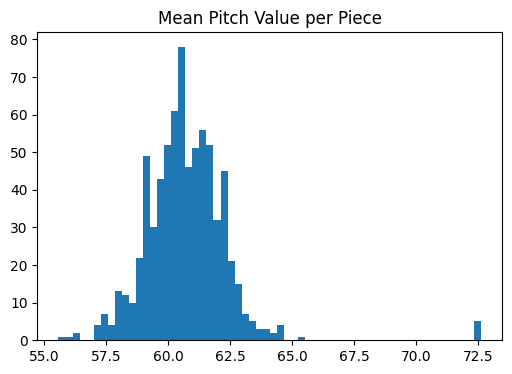

In [16]:
mean_pitches = {}
for file, data in parsed_midis.items():
    pitch_distribution = data['pitch_counts']
    weighted_sum = sum(key * value for key, value in pitch_distribution.items())
    total_occurrences = sum(pitch_distribution.values())
    if total_occurrences != 0:
        mean = weighted_sum / total_occurrences
        mean_pitches[file] = mean

fig = plt.figure(figsize=(6,4))
plt.hist(list(mean_pitches.values()), bins=60)
plt.title('Mean Pitch Value per Piece')
plt.show()

In [17]:
top_outliers = [file for file, mean in mean_pitches.items() if mean > 70]
top_outliers

['file_10532.mid',
 'file_10533.mid',
 'file_498.mid',
 'file_536.mid',
 'file_537.mid']

The outlier MIDIs are all one octave too high. Probably an issue with how they were exported from the music notation software. We can simply transpose them one octave down.

In [18]:
def transpose_piece(piece, n):
    transposed_piece = []
    for event in piece:
        if event.startswith('NOTE'):
            _, pitch = event.split('=')
            transposed_piece.append(f'NOTE={int(pitch)+n}')
        else:
            transposed_piece.append(event)  
    return transposed_piece


for file, data in parsed_midis.items():
    if file in top_outliers:
        data['events'] = transpose_piece(data['events'], -12)

## Tempo

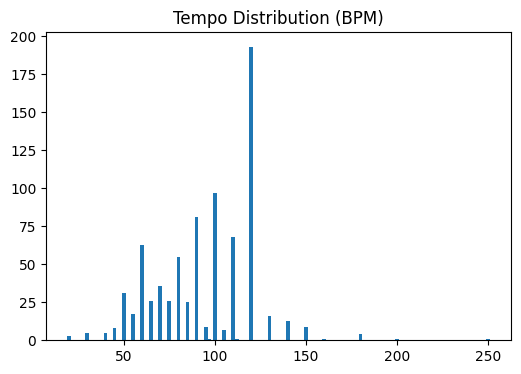

In [19]:
tempo_counts = agg_stats['tempo_counts']
fig = plt.figure(figsize=(6,4))
plt.bar(list(tempo_counts.keys()), list(tempo_counts.values()), width=2)
plt.title('Tempo Distribution (BPM)')
plt.show()

In [20]:
tempo_outliers = []
for file, data in parsed_midis.items():
    tempi = data['tempi']
    for tempo in tempi:
        if tempo > 400:
            tempo_outliers.append(file)

tempo_outliers

[]

In [21]:
files_to_remove.update(set(tempo_outliers))

## Note Durations

In [22]:
duration_counts = agg_stats['duration_counts']
durations = sorted(list(duration_counts.keys()))
np.array(durations)

array([ 0.0625,  0.125 ,  0.1875,  0.25  ,  0.3125,  0.375 ,  0.4375,
        0.5   ,  0.5625,  0.625 ,  0.6875,  0.75  ,  0.875 ,  0.9375,
        1.    ,  1.125 ,  1.25  ,  1.3125,  1.375 ,  1.5   ,  1.625 ,
        1.75  ,  1.875 ,  2.    ,  2.125 ,  2.25  ,  2.375 ,  2.5   ,
        2.625 ,  2.75  ,  2.875 ,  3.    ,  3.125 ,  3.25  ,  3.375 ,
        3.5   ,  3.625 ,  3.75  ,  3.875 ,  4.    ,  4.25  ,  4.375 ,
        4.5   ,  4.6875,  4.75  ,  5.    ,  5.125 ,  5.25  ,  5.5   ,
        5.75  ,  6.    ,  6.25  ,  6.5   ,  6.75  ,  7.    ,  7.25  ,
        7.5   ,  7.625 ,  8.    ,  8.625 , 18.25  ])

In [23]:
len(durations)

61

The values are measured in fractions of quarter notes. Hence, 0.0625 would be a 1/64 note. Most note durations are multiples of that. However, some have repeating 6es or 3s after the decimal point.

The .333, etc. durations (mostly?) seem to come from genuine triplet passages. The piece in file_516, for instance, is John Downlands famous "Frog Galliard" one variation of which is in triplets. However, they are very rare and we could think about rounding them when creating the trainig dataset.

## MEASURES

First, let's remove empty measures.

In [24]:
def remove_empty_measures(events):
    def has_note_event(measure):
        return any(event.startswith('NOTE=') for event in measure)
    
    # iterate through the list and remove empty measures
    filtered_events = []
    current_measure = []
    
    for event in events:
        if event == 'MEASURE':
            if has_note_event(current_measure):
                filtered_events.extend(current_measure)
            current_measure = []
        current_measure.append(event)
    
    # add the last measure if it contains NOTE events
    if has_note_event(current_measure):
        filtered_events.extend(current_measure)
    
    return filtered_events

for file, data in parsed_midis.items():
    data['events'] = remove_empty_measures(data['events'])

In [25]:
# check for measures that don't have 3 or 4 quarter beats 

sus_files = set()
for file, data in parsed_midis.items():
    events = data['events']

    current_time = 0
    expected_time = 0
    for index, event in enumerate(events):
        if events[index-1] == 'STEP':
            _, delta = event.split('=')
            delta = float(delta)
            current_time += delta
            
        if event == 'EVEN':
            if current_time - expected_time != 0:
                sus_files.add(file)
            expected_time = 4
            current_time = 0
            
        if event == 'TRIPLE':
            if current_time - expected_time != 0:
                sus_files.add(file)
            expected_time = 3
            current_time = 0

sus_files

{'file_12353.mid',
 'file_12450.mid',
 'file_12469.mid',
 'file_12526.mid',
 'file_12597.mid',
 'file_13351.mid',
 'file_13384.mid',
 'file_547.mid',
 'file_588.mid',
 'file_7894.mid',
 'file_920.mid'}

In [26]:
files_to_remove.update(sus_files)

len(sus_files)

11

Some manual labour

file_12353.mid: ??
file_12469.mid: ??
file_12526.mid ??
file_588.mid: ??
file_920.mid: ??

file_12230.mid: everything was shifted one quarter to the left
file_12235.mid: everything was shifted one quarter to the left
file_12242.mid: deleted anacrusis 
file_12249.mid: deleted anacrusis 
file_10549.mid: changed 6/4 measures (used to simulate triplets) to 3/4
file_12450.mid changed on 6/4 measure to 3/4
file_12531.mid: removed about half the piece because it was in 9/8(?)
file_12597.mid: changed onee 6/4 measure to 3/4
file_12912.mid: some weird (defective) time signature changes (seemd to overlap), removed note events, hopefully gets filtered out when removing empty measures.
file_13163.mid: changed some 6/4 to 3/4 and removed some note events
file_13165.mid: changed some 6/4 and 8/4 to 4/4 and removed some notes
file_13166.mid: one 8/4 to 4/4
file_13175.mid: piece in 6/4, scaled everything by 0.5 and changed to 3/4
file_13254.mid: piece in 6/4, scaled everything by 0.5 and changed to 3/4
file_13351.mid: deleted some notes, seems off still
file_13384.mid: changed one 6/4 to 3/4
file_13830.mid: piece in 2/4 changed to 4/4
file_14015.mid: piece in 2/4 changed to 4/4
file_14043.mid: piece in 2/4 changed to 4/4
file_14064.mid: piece in 2/4 changed to 4/4
file_14065.mid: piece in 2/4 changed to 4/4
file_14072.mid: piece in 2/4 changed to 4/4
file_2450.mid: changed first measure and removed notes in 1/4 measure
file_3410.mid: piece in 2/4 changed to 4/4
file_547.mid: changed some 6/4 to 3/4
file_7894.mid: removed last two measures
file_938.mid: removed notes in a (defective?) 2/4  bar
file_595.mid shifted note and edited beginning
file_70.mid: 24 quarters long bars were split to 4/4, deleted anacrusis
file_76.mid: changed 6/4(8) to 3/4
file_7894.mid: changed 4/4 to 3/4
file_7897.mid: changed 4/4 to 3/4
file_84.mid: deleted an empty 2/4 and 4/4 bar
file_942.mid: shifted everything one quarter to the right
"""

# Create the Training Dataset

In [27]:
len(parsed_midis)

737

In [28]:
parsed_midi_cleaned = {}

for file, data in parsed_midis.items():
    if file not in files_to_remove:
        parsed_midi_cleaned[file] = data

len(parsed_midi_cleaned)

726

In [29]:
def remove_duplicates(parsed_midis):
    unique_parsed_midis = {}
    event_lists = set()
    
    for file_name, data in parsed_midis.items():
        events = tuple(data.get('events', []))
    
        if events not in event_lists:
            event_lists.add(events)
            unique_parsed_midis[file_name] = data
    
    return unique_parsed_midis

parsed_midis_no_dupl = remove_duplicates(parsed_midi_cleaned)

len(parsed_midis_no_dupl)

680

In [31]:
from importlib import reload
from midi_utils import preprocessing 

reload(preprocessing)

#output_directory = os.path.join(wd, 'data', 'training_data', 'solo_pieces', '8_bars_aug')

measures, training, validation, tokenizer = preprocessing.split_and_transpose(
    parsed_midis_no_dupl,
    ren_lute_df,
    n_bars=6,
    transpose=True,
    save_data=False,
    output_directory=output_directory
)

Number of 6 measure sequences: 12252

Tokens in 6 measure sequences:
Median number of tokens: 212.0
Mean number of tokens: 239.03199477636304
Standard deviation: 99.53641133127655



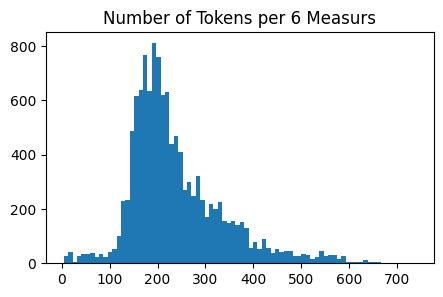

In [33]:
measure_lengths = [len(measure) for measure in measures]

print(f'Number of 6 measure sequences: {len(measures)}\n')
print('Tokens in 6 measure sequences:')
print(f'Median number of tokens: {np.median(measure_lengths)}')
print(f'Mean number of tokens: {np.mean(measure_lengths)}')
print(f'Standard deviation: {np.std(measure_lengths)}\n')

fig = plt.figure(figsize=(5,3))
plt.hist(measure_lengths, bins=80)
#plt.vlines(140, 0, 7000, colors='black', linestyles='dashed')
#plt.vlines(250, 0, 7000, colors='black', linestyles='dashed')
#plt.vlines(370, 0, 7000, colors='black', linestyles='dashed')
plt.title('Number of Tokens per 6 Measurs')
plt.show()

In [34]:
def count_measures(seq):
    i=0
    for event in seq:
        if event == 'MEASURE':
            i += 1
    return i

In [35]:
short_seqs = [measure for measure in measures if count_measures(measure) < 6]

In [36]:
len(measures), len(short_seqs)

(12252, 738)

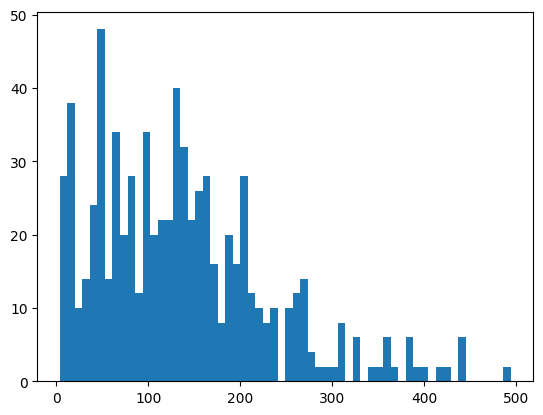

In [38]:
plt.hist([len(measure) for measure in short_seqs], bins=60)
plt.show()

In [153]:
from midi_utils.encoding_decoding import decode_tokens_to_midi
import random
random.seed(4)

short_measures = [measure for measure in measures if (len(measure) > 130 and len(measure) < 140)]

samples = random.sample(short_measures, 10)

for index, sample in enumerate(samples):
    midi_object = decode_tokens_to_midi(sample, tempo=100)
    midi_object.write(os.path.join(wd, 'samples', f'sample_{index+1}.mid'))

In [ ]:
# generate from prompt
# find the first incomplete/incorrect measure and delete everything after it
# remove and save the first measure
# generate from resulting measures
# etc.

In [58]:
def find_faulty_measure(events):

    current_time = 0
    expected_time = 0
    measure_index = 0
    
    for index, event in enumerate(events):
        if events[index-1] == 'STEP':
            _, delta = event.split('=')
            delta = float(delta)
            current_time += delta
            
        if event == 'EVEN':
            if current_time - expected_time != 0:
                return measure_index
            measure_index = index - 1
            expected_time = 4
            current_time = 0
            
        if event == 'TRIPLE':
            if current_time - expected_time != 0:
                if current_time - expected_time != 0:
                    return measure_index
            measure_index = index - 1
            expected_time = 3
            current_time = 0

    if current_time - expected_time != 0:
        return measure_index
    else:
        return index + 1


def find_second_measure(events):
    measure_counter = 0
    for index, event in enumerate(events):
        if event == 'MEASURE':
            measure_counter +=1
        if measure_counter == 2:
            return index
    raise ValueError('Input sequence must have at least two measures.')


def create_new_input(events):

    second_measure_index = find_second_measure(events)
    print(f'second mesure: {second_measure_index}')
    faulty_measure_index = find_faulty_measure(events)
    print(f'faulty measure: {faulty_measure_index}')

    first_measure = events[:second_measure_index]
    new_input = events[second_measure_index:faulty_measure_index]

    return first_measure, new_input


def generate_measures(model, tokenizer, seed, num_gens, max_len, proba, tempo=100, save_midi=False, output_path=None):

    generated_events = generate_midi(
        model=model,
        tokenizer=tokenizer,
        seed=seed,
        max_len=max_len,
        p=proba,
        tempo=100,
        save_midi=False
    )[0]

    piece = []
    for i in range(num_gens):

        first_measure, new_input = create_new_input(generated_events)
        piece.append(first_measure)
        
        generated_events = generate_midi(
            model=model,
            tokenizer=tokenizer,
            seed=new_input,
            max_len=max_len,
            p=proba,
            tempo=100,
            save_midi=False
        )[0]

    piece.append(generated_events)
    final_piece = [event for part in piece for event in part]

    midi_object = decode_tokens_to_midi(final_piece, tempo=tempo)

    if save_midi:
        midi_object.write(output_path)

    return final_piece, midi_object
        
        
    

In [56]:
test_events = ['MEASURE', 'TRIPLE', 'NOTE=46', 'DELTA=2.0', 'STEP', 'DELTA=2.0', 'NOTE=48', 'DELTA=1.0', 'STEP', 'DELTA=1.0',
               'MEASURE', 'TRIPLE', 'NOTE=46', 'DELTA=1.0', 'STEP', 'DELTA=1.0', 'NOTE=48', 'DELTA=2.0', 'STEP', 'DELTA=2.0',
               'MEASURE', 'EVEN', 'NOTE=46', 'DELTA=1.0', 'STEP', 'DELTA=1.0', 'NOTE=48', 'DELTA=2.0', 'STEP', 'DELTA=2.0', 'NOTE=60', 'DELTA=1.0', 'STEP', 'DELTA=1.0',
               'MEASURE', 'TRIPLE', 'NOTE=46', 'DELTA=2.0', 'STEP', 'DELTA=2.0']

create_new_input(test_events)

10
34


(['MEASURE',
  'TRIPLE',
  'NOTE=46',
  'DELTA=2.0',
  'STEP',
  'DELTA=2.0',
  'NOTE=48',
  'DELTA=1.0',
  'STEP',
  'DELTA=1.0'],
 ['MEASURE',
  'TRIPLE',
  'NOTE=46',
  'DELTA=1.0',
  'STEP',
  'DELTA=1.0',
  'NOTE=48',
  'DELTA=2.0',
  'STEP',
  'DELTA=2.0',
  'MEASURE',
  'EVEN',
  'NOTE=46',
  'DELTA=1.0',
  'STEP',
  'DELTA=1.0',
  'NOTE=48',
  'DELTA=2.0',
  'STEP',
  'DELTA=2.0',
  'NOTE=60',
  'DELTA=1.0',
  'STEP',
  'DELTA=1.0'])

In [47]:
find_second_measure(test_events)

10